# Projet 4 - Analysez les ventes de votre entreprise

# Partie I - Nettoyage des données

Nous allons étudier les ventes de livres en ligne de la société.

Pour se faire nous allons tout d'abord nettoyer les données provenant de la base de donnée, ensuite les analyser pour en tirer les informations pertinentes, et enfin vérifier les corrélations suivantes :

* Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?
* Y a-t-il une corrélation entre l'âge des clients et :
    * Le montant total des achats ;
    * La fréquence d’achat (ie. nombre d'achats par mois par exemple) ;
    * La taille du panier moyen (en nombre d’articles) ;
    * Les catégories de produits achetés.

## Table des matières

1. __Importation des données__


2. __Vérification de données manquantes__

    1. Fichier customers
    2. Fichier products
    3. Fichier transactions

    
    
3. __Nettoyage des fichiers__

    1. Nettoyage des données de test
    2. Mise au format Datetime de la colonne date
    3. Suppression des semaines sans vente de livres de categ 1
    

4. __Préparation du dataFrame de travail__

    1. Assemblage des 3 fichiers en 1 seul
    2. Création de nouvelles colonnes
    3. Test Unitaire
    
    
5. __Exportations des Data Frame en fichier csv__

## 1. Importation des données

Dans un premier temps, nous allons importer les données téléchargées depuis le site OCR

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(color_codes = True)

In [2]:
customers = pd.read_csv('./Dataset/customers.csv')
products = pd.read_csv('./Dataset/products.csv')
transactions = pd.read_csv('./Dataset/transactions.csv', parse_dates=[1])

Nous allons, maintenant, regarder les dataFrames pour remarquer les valeurs manquantes

## 2. Vérification de données manquantes

### A. Fichier *customers*

In [3]:
customers.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

Il n'y a pas de valeur nulle dans ce fichier.

In [4]:
customers.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


Les valeurs numériques sont comprises entre 1929 et 2004, ce qui semble normal

In [5]:
customers.count() == customers.drop_duplicates('client_id').count()

client_id    True
sex          True
birth        True
dtype: bool

Il n'y a pas d'*id_client* en double.

In [6]:
customers['sex'].value_counts()

f    4491
m    4132
Name: sex, dtype: int64

Les valeurs pour la colonne *sex* ne comportent que des valeurs *f* et *m*

In [7]:
customers['birth'].value_counts()

2004    440
1979    215
1988    207
1986    203
1978    199
       ... 
1935      8
1932      6
1931      4
1930      4
1929      3
Name: birth, Length: 76, dtype: int64

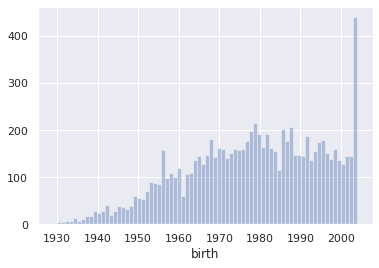

In [8]:
sns.distplot(customers['birth'], kde=False, bins=76)

Nous avons, ici, pour les années de naissance, environ 5% des clients qui sont nés en 2004. Est-ce un erreur ou une particularité, à relever, du site, qui cible les adolescents. Est-ce que dans l'inscription en ligne, cette année comprend les clients nés en 2004 et avant ?

Le reste du dataFrame ne présente pas de valeurs manquantes ou erronées

### B. Fichier *products*

In [9]:
products.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

Il n'y a pas de valeur nulle présente dans ce fichier

In [10]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


Il y a un ou plusieurs produit dont la valeur est négative.

In [11]:
products['id_prod'].count() == products.drop_duplicates('id_prod').count()

id_prod    True
price      True
categ      True
dtype: bool

il n'y a pas d'*id_prod* en double

In [12]:
products['price'].value_counts()

4.99     85
6.99     84
3.99     80
5.99     78
8.99     74
         ..
4.13      1
2.84      1
13.13     1
18.77     1
9.00      1
Name: price, Length: 1455, dtype: int64

In [13]:
products['categ'].value_counts()

0    2309
1     739
2     239
Name: categ, dtype: int64

Il y a trois valeurs pour *categ* 1, 2 et 3

In [14]:
products.nsmallest(10, 'price')

,id_prod,price,categ
731,T_0,-1.00,0
2272,0_528,0.62,0
2355,0_202,0.62,0
370,0_120,0.66,0
1211,0_1844,0.77,0
1530,0_1620,0.80,0
2302,0_1364,0.81,0
2425,0_612,0.88,0
2772,0_902,0.92,0
686,0_2138,0.93,0


In [15]:
products.nlargest(10, 'price')

,id_prod,price,categ
947,2_2,300.00,2
724,2_76,254.44,2
394,2_158,247.22,2
1436,2_167,236.99,2
2779,2_30,233.54,2
1960,2_125,231.99,2
2487,2_166,230.04,2
786,2_40,228.11,2
10,2_228,225.17,2
1896,2_4,222.97,2


Nous remarquons qu'un produit à une valeur de -1, est-ce qu'il correspond à une valeur test, comme le 'T' dans son identifiant le laisse présager ?

Le reste du dataFrame ne présente pas de valeurs manquantes ou erronées.

### C. Fichier *transactions*

In [16]:
transactions.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [17]:
transactions.describe()

,id_prod,date,session_id,client_id
count,337016,337016,337016,337016
unique,3266,336855,169195,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,1081,13,200,12855


Nous constatons que certains articles n'ont pas été vendu, nous avons 3266 produits uniques de vendus sur un total de 3287 produits référencés. De plus, nous avons certains clients qui n'ont effectué aucun achat, nous avons, dans le dataframe transaction 8502 clients uniques alors qu'il y a 8623 clients d'enregistrés.

Nous avons dans la colonne date une valeur test : test_2021-03-01 02:30:02.237413

## 3. Nettoyage des fichiers

### A. Nettoyage des données de test

Tout d'abord, nous allons enlever les données de test rentrées dans les dataFrames.

In [18]:
transactions[transactions['date'].str.contains('test')]

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1
...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1


Nous remarquons que les tests ont été fait avec d'autres éléments prédéfinis. Nous allons rechercher ces éléments pour les enlever de nos dataFrames pour éviter de fausser notre analyse.

In [19]:
transactions.loc[transactions['date'].str.contains('test')].describe()

,id_prod,date,session_id,client_id
count,200,200,200,200
unique,1,39,1,2
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,200,13,200,106


Nous remarquons que nous avons un produit unique (T_0), une session unique (s_0), et deux clients uniques (ct_0 et ct_1). Nous allons enlever ces éléments après vérification

In [20]:
transactions.loc[transactions['id_prod'] == 'T_0'].describe()

,id_prod,date,session_id,client_id
count,200,200,200,200
unique,1,39,1,2
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,200,13,200,106


Le client T_0 n'a été utilisé que pour les 200 achats tests

In [21]:
transactions.loc[transactions['session_id'] == 's_0'].describe()

,id_prod,date,session_id,client_id
count,200,200,200,200
unique,1,39,1,2
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,200,13,200,106


De même, la session s_0 n'a été utilisé que pour les 200 achats tests

In [22]:
transactions.loc[transactions['client_id'] == 'ct_0'].describe()

,id_prod,date,session_id,client_id
count,106,106,106,106
unique,1,37,1,1
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,106,9,106,106


In [23]:
transactions.loc[transactions['client_id'] == 'ct_1'].describe()

,id_prod,date,session_id,client_id
count,94,94,94,94
unique,1,37,1,1
top,T_0,test_2021-03-01 02:30:02.237443,s_0,ct_1
freq,94,5,94,94


Pour finir, les clients ct_0 et ct_1 ont été également utilisé que pour les 200 achats tests ; 106 avec le client ct_0 et 94 avec le client ct_1

Nous allons supprimer les 200 lignes contenant des dates de test

In [24]:
transactions = transactions[~transactions['date'].str.contains('test')]

Nous allons effacer le produit test T_0, d'une valeur négative, de la dataFrame products

In [25]:
products = products[~(products['id_prod'] == 'T_0')]

Nous allons effacer les clients ct_0 et ct_1 de la dataFrame customers

In [26]:
customers[customers['client_id'].str.contains('ct_')].describe()

,birth
count,2.0
mean,2001.0
std,0.0
min,2001.0
25%,2001.0
50%,2001.0
75%,2001.0
max,2001.0


Nous n'avons que deux clients possèdant le préfixe 'ct', les clients tests, que nous allons enlever du dataFrame

In [ ]:
x

In [27]:
customers = customers[~customers['client_id'].str.contains('ct_')]

Nous allons convertir la colonne date du dataFrame transactions en valeur de type datetime64

### B. Mise au format Datetime de la colonne *date*

In [28]:
transactions['date'] = pd.to_datetime(transactions['date'])

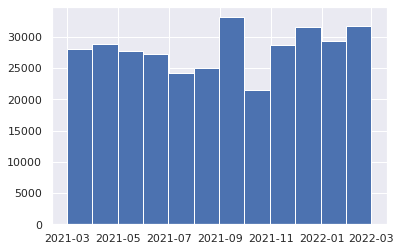

In [29]:
transactions['date'].hist(bins = 12)

Nous constatons que les dates s'étalent sur 1 an de Mars 2021 à Mars 2022.

### C. Suppression des semaines sans vente de livres de categ 1

Nous avons vu durant l'analyse de données que la vente de livres de categ fut nulle durant les semaines 40 à 42, et eu un volume plus faible durant les semaines 39 et 43. Ainsi, pour garder un data Frame homogène, nous avons allons enlever ses 5 semaines, afin de ne pas fausser les valeurs des corrélations. Voir le paragraphes 6.A

Nous allons faire une copie de la database et enlever les semaines 39 à 43 pendant la préparation du Data Frame

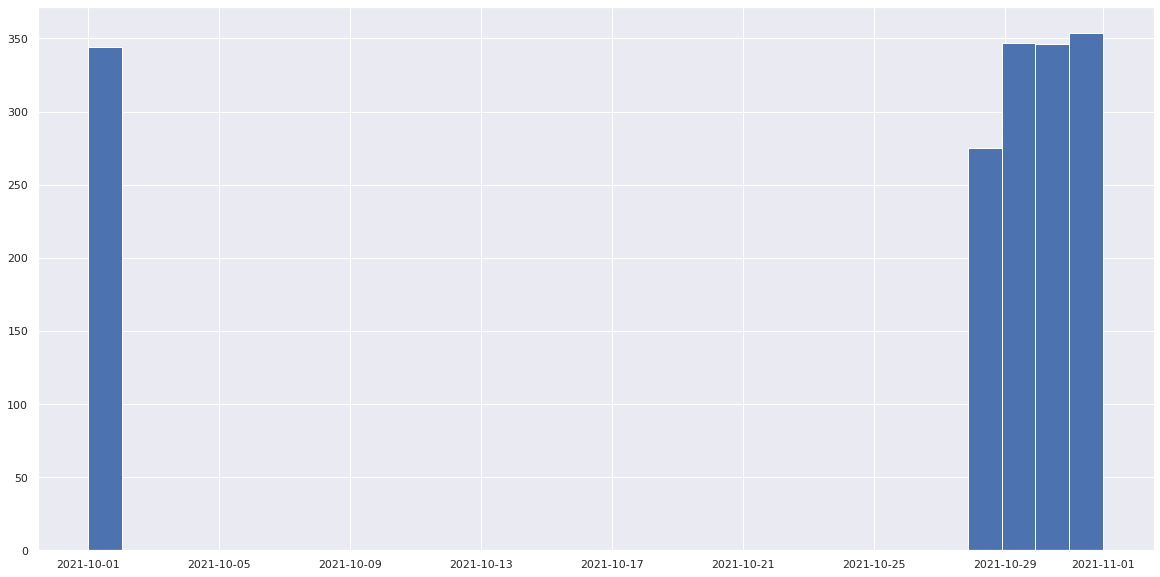

In [69]:
fig, axes = plt.subplots(1, 1, figsize = (20, 10))
df_transactions[(df_transactions['date'].dt.month == 10) & (df_transactions['categ'] == 1)]['date'].hist(bins = 30)
plt.savefig('pictures/vente_octobre.png')

Nous voyons qu'il n'y a pas de vente entre le 2 Octobre et le 36 octobre 2021

In [82]:
df_transactions[(df_transactions['date'].dt.month == 11) & (df_transactions['categ'] == 2)]['date'].count()

1373

## 4. Préparation du dataFrame de travail

### A. Assemblage des 3 fichiers en 1 seul

Nous allons merger les 3 dataFrames en 1 seul pour faciliter l'analyse des données

In [30]:
df_transactions = transactions.merge(customers, how = 'inner', on = 'client_id')

In [31]:
df_transactions = df_transactions.merge(products, how = 'inner', on= 'id_prod')

In [34]:
df_transactions.describe()

,birth,price,categ
count,336713.000000,336713.000000,336713.000000
mean,1977.823568,17.215189,0.430156
std,13.524433,17.855445,0.591082
min,1929.000000,0.620000,0.000000
25%,1971.000000,8.610000,0.000000
50%,1980.000000,13.900000,0.000000
75%,1987.000000,18.990000,1.000000
max,2004.000000,300.000000,2.000000


Nous utilisons des *inner joints* pour éviter l'ajout de valeur nulle dans notre dataFrame. Nous avons des clients et des produits qui n'ont jamais été vendus, mais également, des commandes avec un produit non référencé.

In [35]:
df = transactions.merge(customers, how = 'outer', on = 'client_id')
df[df['id_prod'].isna()]

,id_prod,date,session_id,client_id,sex,birth
336816,NaN,NaT,NaN,c_8253,f,2001
336817,NaN,NaT,NaN,c_3789,f,1997
336818,NaN,NaT,NaN,c_4406,f,1998
336819,NaN,NaT,NaN,c_2706,f,1967
336820,NaN,NaT,NaN,c_3443,m,1959
336821,NaN,NaT,NaN,c_4447,m,1956
336822,NaN,NaT,NaN,c_3017,f,1992
336823,NaN,NaT,NaN,c_4086,f,1992
336824,NaN,NaT,NaN,c_6930,m,2004
336825,NaN,NaT,NaN,c_4358,m,1999


Nous avons 21 clients qui n'ont jamais effectué d'achats sur le site.

In [40]:
f"il y a {df_transactions.drop_duplicates('client_id')['client_id'].count()} clients soit 23 de moins que dans le fichiers Customers - les 2 clients Test et les 21 clients n'ayant jamais achetés sur le site"

"il y a 8600 clients soit 23 de moins que dans le fichiers Customers - les 2 clients Test et les 21 clients n'ayant jamais achetés sur le site"

In [ ]:
df = transactions.merge(products, how = 'outer', on = 'id_prod')
df[df['client_id'].isna()]

Nous avons 22 produits qui n'ont jamais été achetés sur le site.

In [42]:
f"il y a {df_transactions.drop_duplicates('id_prod')['id_prod'].count()} clients soit 23 de moins que dans le fichiers Customers - les 2 clients Test et les 21 clients n'ayant jamais achetés sur le site"

"il y a 3264 clients soit 23 de moins que dans le fichiers Customers - les 2 clients Test et les 21 clients n'ayant jamais achetés sur le site"

In [45]:
transactions[~transactions['id_prod'].isin(products['id_prod'].drop_duplicates())].drop_duplicates('id_prod')

,id_prod,date,session_id,client_id
6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533
10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954
14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120
17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964
21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580
...,...,...,...,...
322710,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167
329417,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790
330490,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189
335531,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595


Nous avons un produit qui n'est pas référencé dans la table *product*

In [46]:
transactions[~transactions['id_prod'].isin(products['id_prod'].drop_duplicates())]

,id_prod,date,session_id,client_id
6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533
10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954
14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120
17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964
21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580
...,...,...,...,...
322710,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167
329417,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790
330490,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189
335531,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595


Il y a une différence de 303 transactions entre le fichiers transactions et le data Frame - 200 des transactions tests et 103 du produit 0_2245 non référencé dans le fichiers *Product*

In [44]:
transactions[~transactions['client_id'].isin(customers['client_id'].drop_duplicates())]

,id_prod,date,session_id,client_id


Tous les clients dans la table *transactions* sont référencés dans la table *customers*

### B. Création de nouvelles colonnes

Maintenant, nous allons rajouter les colonnes suivantes :
   * 'age', 
   * 'cat_age', 
   * 'cat_price', 
   * 'weekday', 
   * 'daytime', 
   * 'month', 
   * 'week', 
   * 'year'

In [ ]:
df_transactions['age'] = df_transactions['date'].dt.year - df_transactions['birth']

Au vue de la répartion des ages vue dans la partie 5.A sur l'analyse des ages, nous allons créer 3 catégorie d'age ; de 18 à 29 ans, de 30 à 59 ans et de 60 à 90 ans

In [ ]:
df_transactions['cat_age'] = pd.cut(x = df_transactions['age'], bins = [0, 29, 59, 99], labels = [1, 2, 3])

Au vue de la répartiton des prix vue dans la partie 5.B sur l'analyse des prix, nous allons créer 3 catégorie d'age ; de 0 à 4.99, de 5 à 19.99 et de 20 à 300.

In [ ]:
df_transactions['cat_price'] = pd.cut(x = df_transactions['price'], bins = [0, 4.99, 19.99, 300], labels = [1, 2, 3])

In [ ]:
df_transactions['weekday'] = df_transactions['date'].dt.dayofweek

In [ ]:
df_transactions['daytime'] = df_transactions['date'].dt.hour

In [ ]:
df_transactions['month'] = df_transactions['date'].dt.month

In [ ]:
df_transactions['week'] = df_transactions['date'].dt.week

In [ ]:
df_transactions['year'] = df_transactions['date'].dt.year

Nous faisons une copie du fichier avant de supprimer les semaines 39 à 43 : 

In [ ]:
df_transactions_old = df_transactions.copy()
df_transactions = df_transactions[~df_transactions['week'].between(39,43)]

Ensuite, nous allons calculer les colonnes suivantes pour regrouper dans chaque lignes les informations des sessions :
   * le montant de la session (session_amount), 
   * le nombre de produit par session (session_nb_produit)
   * la moyenne des *categ* de la session (session_categ_mean)

In [ ]:
df_transactions = df_transactions.merge(df_transactions.groupby('session_id')['price'].sum().reset_index(name = 'session_amount'), how='left', on='session_id')

In [ ]:
df_transactions = df_transactions.merge(df_transactions.groupby('session_id')['id_prod'].count().reset_index(name = 'session_nb_produit'), how='left', on='session_id')

In [ ]:
df_transactions = df_transactions.merge(df_transactions.groupby('session_id')['categ'].mean().reset_index(name = 'session_categ_mean'), how='left', on='session_id')

Nous allons créer les colonnes des habitudes d'achats des clients : 
   * le nombre de session d'achat fait par le client (nombre_achat_client), 
   * les 4 catégories du nombre de session d'achat des clients par quartile (cat_nb_achat), 
   * le nombre de livre acheté par le client (nombre_livre_client), 
   * le montant total d'achat (montant_total), 
   * le rang du client en fonction du total de ses achats (montant_total_rang), 
   * les 4 catégories du montant d'achat total des clients par quartile (cat_montant_total),
   * la taille moyenne de son panier (session_nb_produit_mean), 
   * le montant moyen de son panier (session_amount_mean),
   * la moyenne *categ* (categ_mean), 
   * la fréquence d'achat par mois, 
   * l'achat moyen par session (freq_achat_mean)
   * le rapport entre nombre_livre_client et montant_total (norm_prix/livre)
   * le boléen pour les clients ayant achetés plus de deux fois le même livre (bookstore)

In [ ]:
df_client = df_transactions.drop_duplicates('session_id').groupby('client_id')

In [ ]:
df_transactions = df_transactions.merge(df_client.count()['id_prod'].reset_index(name = 'nombre_achat_client'), how='left', on='client_id')

In [ ]:
df_transactions['cat_nb_achat'] = pd.cut(x = df_transactions['nombre_achat_client'], bins = [0, df_transactions.quantile(0.25)['nombre_achat_client'], df_transactions.quantile(0.5)['nombre_achat_client'], df_transactions.quantile(0.75)['nombre_achat_client'], df_transactions.quantile(1)['nombre_achat_client']], labels = [1, 2, 3, 4])

In [ ]:
df_transactions = df_transactions.merge(df_transactions.groupby('client_id').count()['id_prod'].reset_index(name = 'nombre_livre_client'), how='left', on='client_id')

In [ ]:
df_transactions = df_transactions.merge(df_client.sum()['session_amount'].reset_index(name = 'montant_total'), how='left', on='client_id')

In [ ]:
df_transactions = df_transactions.merge(df_client.sum()['session_amount'].rank(ascending = False).reset_index(name = 'montant_total_rang'), how='left', on='client_id')

In [ ]:
df_transactions['cat_montant_total'] = pd.cut(x = df_transactions['montant_total'], bins = [0, df_transactions.quantile(0.25)['montant_total'], df_transactions.quantile(0.5)['montant_total'], df_transactions.quantile(0.75)['montant_total'], df_transactions.quantile(1)['montant_total']], labels = [1, 2, 3, 4])

In [ ]:
df_transactions = df_transactions.merge(df_client.mean()['session_nb_produit'].reset_index(name = 'session_nb_produit_mean'), how='left', on='client_id')

In [ ]:
df_transactions = df_transactions.merge(df_client.mean()['session_amount'].reset_index(name = 'session_amount_mean'), how='left', on='client_id')

In [ ]:
df_transactions = df_transactions.merge(df_client.mean()['categ'].reset_index(name = 'categ_mean'), how='left', on='client_id')

In [ ]:
df_transactions = df_transactions.merge(((df_transactions.drop_duplicates('session_id').groupby(['month', 'client_id']).count()['price']).unstack().fillna(0).sum()/12).reset_index(name = 'freq_achat_mean'), how='left', on='client_id')

In [ ]:
df_transactions['norm_prix/livre'] = df_transactions['montant_total']/df_transactions['nombre_livre_client']

In [ ]:
df = df_transactions.groupby(['id_prod', 'client_id']).count()['price']
df_transactions['bookstore'] = 0
df_transactions.loc[df_transactions['client_id'].isin(df[(df > 2)].unstack().columns), 'bookstore'] = 1

Nous allons créer les colonnes pour les livres : 
   * le nombre de livre vendu en terme de vente (book_total_sold), 
   * le rang du livre en terme de vente (book_rank_sold), 
   * le montant total pour ce livre (book_total_price),
   * le rang du livre en terme de montant (book_rank_price)

In [ ]:
df_transactions = df_transactions.merge(df_transactions.groupby('id_prod').count()['price'].reset_index(name = 'book_total_sold'), how='left', on='id_prod')

In [ ]:
df_transactions = df_transactions.merge(df_transactions.groupby('id_prod').count()['price'].rank(ascending = False).reset_index(name = 'book_rank_sold'), how='left', on='id_prod')

In [ ]:
df_transactions = df_transactions.merge(df_transactions.groupby('id_prod').sum()['price'].reset_index(name = 'book_total_price'), how='left', on='id_prod')

In [ ]:
df_transactions = df_transactions.merge(df_transactions.groupby('id_prod').sum()['price'].rank(ascending = False).reset_index(name = 'book_rank_price'), how='left', on='id_prod')

Nous allons créer une colonne pour avoir une *categ* normalisée par rapport au nombre de clients dans chaque age et chaque catégorie d'age

In [ ]:
df_transactions['norm_categ_cat_age'] = 99
for i in range(3):
    for j in range (1,4):
        filt = (df_transactions['categ'] == i) & (df_transactions['cat_age'] == j)
        norm = 10000 / df_transactions[filt]['categ'].count()
        df_transactions.loc[filt, 'norm_categ_cat_age'] = norm

### C. Test Unitaire

In [ ]:
df_transactions[df_transactions['session_id'] == 's_10146']

Nous testons, pour une sessions, si les valeurs calculer sont correctes. Nous avons bien 6 produits, ayant une moyenne de 1/6 pour *session_categ* avec un montant de 53.89 qui est la somme des produits de la session.

## 5. Exportations des Data Frame en fichier csv

In [ ]:
df_transactions.to_csv(path_or_buf='./Export/transactions.csv', index=False)
df_transactions_old.to_csv(path_or_buf='./Export/transactions_w_october.csv', index=False)